# Malware detection model 

## Imports

In [6]:
# Imports
import numpy as np # Support for large arrays and matrices, along with high-level mathematical functions.
import seaborn as sns # Graphing/Plotting module.
import pandas as pd # CSV handling with operations on tabular data.
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from ast import literal_eval # Transform/Parse a string-list into a proper list.
import requests # GET requets to scrap a url/website
from utils import save_classification_report

## Read Data and Preprocess it

In [22]:
# Read Data
''' 
There are 2 datasets available for you to use - 
1. 'mta' 
2. 'ustc'
Make sure that 
the path to the .csv files is correct. the following code loads the data from .csv file
into a DataFrame.
'''

#dataset_type = 'mta' # or 'ustc'
dataset_type = 'ustc'

filepath = f'./datasets/{dataset_type}/xy_train.csv'
df = pd.read_csv(filepath)
df

,Unnamed: 0.1,expiration_id,src_ip,src_mac,src_oui,src_port,dst_ip,dst_mac,dst_oui,dst_port,...,user_agent,content_type,udps.n_bytes,udps.protocol_header_fields,udps.handshake_packets_duration,udps.n_bytes_per_packet,udps.stnn_image,file_name,label,malware_family
0,NaN,0,10.0.0.16,fc:aa:14:06:36:f1,fc:aa:14,64059,104.244.42.193,c0:ff:d4:7f:d7:4d,c0:ff:d4,443,...,NaN,NaN,"[0.08627450980392157, 0.011764705882352941, 0....","[[0, 0, 0, 65535], [1, 0, 84, 14600], [0, 0, 0...",0.084,"[[0.08627450980392157, 0.011764705882352941, 0...","[[0.0, 86.0, 16.46875, 31.691032, 1.5046571, 5...",W_Pc_ie_10-06__14_03_26.pcap.TCP_10-0-0-16_640...,benign,benign
1,42817.0,0,10.0.2.108,08:00:27:fb:bb:39,08:00:27,63365,93.189.89.83,52:54:00:12:35:02,52:54:00,8080,...,Mozilla/5.0 (Windows NT 6.1; Trident/7.0; rv:1...,octet/binary,"[0.3137254901960784, 0.30980392156862746, 0.32...","[[0, 0, 0, 20480], [1, 0, 47, 65535], [0, 0, 0...",381461.894,"[[0.3137254901960784, 0.30980392156862746, 0.3...","[[0.0, 191375730.0, 11920686.0, 46907596.0, 3....",0000-00-00-malware-cridex.csv,malware,dridex
2,36216.0,0,10.0.2.108,08:00:27:fb:bb:39,08:00:27,50163,93.189.89.83,52:54:00:12:35:02,52:54:00,8080,...,Mozilla/5.0 (Windows NT 6.1; Trident/7.0; rv:1...,octet/binary,"[0.3137254901960784, 0.30980392156862746, 0.32...","[[0, 0, 0, 20480], [1, 0, 48, 65535], [0, 0, 0...",382614.926,"[[0.3137254901960784, 0.30980392156862746, 0.3...","[[0.0, 191412320.0, 11956718.0, 47048948.0, 3....",0000-00-00-malware-cridex.csv,malware,dridex
3,NaN,0,10.0.0.1,fc:aa:14:06:36:dc,fc:aa:14,52629,104.244.43.199,c0:ff:d4:7f:d7:4d,c0:ff:d4,443,...,NaN,NaN,"[0.08627450980392157, 0.011764705882352941, 0....","[[0, 0, 0, 8192], [1, 0, 72, 14600], [0, 0, 0,...",0.072,"[[0.08627450980392157, 0.011764705882352941, 0...","[[0.0, 7004.0, 331.86365, 1490.4985, 4.361895,...",W_Pc_ff_09-08__18_05_53.pcap.TCP_10-0-0-1_5262...,benign,benign
4,NaN,0,10.0.0.16,fc:aa:14:06:36:f1,fc:aa:14,56174,199.59.149.230,c0:ff:d4:7f:d7:4d,c0:ff:d4,443,...,NaN,NaN,"[0.08627450980392157, 0.011764705882352941, 0....","[[0, 0, 0, 65535], [1, 0, 213, 14600], [0, 0, ...",0.213,"[[0.08627450980392157, 0.011764705882352941, 0...","[[0.0, 30038.0, 1611.9062, 6050.424, 4.0028157...",W_Pc_ie_09-08__18_05_50.pcap.TCP_10-0-0-16_561...,benign,benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40733,NaN,0,10.0.0.20,ac:87:a3:39:05:cc,ac:87:a3,52231,216.58.210.66,c0:ff:d4:7f:d7:4d,c0:ff:d4,443,...,NaN,NaN,"[0.08627450980392157, 0.011764705882352941, 0....","[[0, 0, 0, 65535], [1, 0, 75, 42540], [0, 0, 0...",0.075,"[[0.08627450980392157, 0.011764705882352941, 0...","[[0.0, 75.0, 10.65625, 24.304, 2.1853943, 66.0...",d_hi_safari_Taylor_Swift_19_24_31_480p.pcap.TC...,benign,benign
40734,50237.0,0,147.32.84.165,08:00:27:b5:b7:19,08:00:27,4100,212.117.171.138,00:1e:49:db:19:c3,00:1e:49,65500,...,NaN,NaN,"[0.6823529411764706, 0.6666666666666666, 0.666...","[[0, 0, 0, 64240], [0, 0, 0, 64240], [1, 0, 23...",0.023,"[[0.6823529411764706, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 187008.0, 6000.9688, 33035.47, 5.385342...",0000-00-00-malware-virut.csv,malware,virut
40735,NaN,0,10.0.0.16,fc:aa:14:06:36:f1,fc:aa:14,54604,199.59.149.230,c0:ff:d4:7f:d7:4d,c0:ff:d4,443,...,NaN,NaN,"[0.08627450980392157, 0.011764705882352941, 0....","[[0, 0, 0, 65535], [1, 0, 213, 14600], [0, 0, ...",0.213,"[[0.08627450980392157, 0.011764705882352941, 0...","[[0.0, 20070.0, 1348.1875, 4568.9966, 3.613659...",W_Pc_ie_09-16__12_42_06.pcap.TCP_10-0-0-16_546...,benign,benign
40736,47154.0,0,10.0.2.108,08:00:27:fb:bb:39,08:00:27,57972,94.23.81.41,52:54:00:12:35:02,52:54:00,80,...,Mozilla/4.0 (compatible; MSIE 7.0; Windows NT ...,NaN,"[0.2784313725490196, 0.27058823529411763, 0.32...","[[0, 0, 0, 8192], [1, 0, 102, 65535], [0, 0, 0...",0.102,"[[0.2784313725490196, 0.27058823529411763, 0.3...","[[0.0, 60988.0, 7962.95, 17059.812, 1.9927912,...",0000-00-00-malware-miuref.csv,malware,miuref


In [23]:
# preprocessing
'''
In the preprocessing you do all needed steps for the dataframe to make the columns/features useable.
for example, there are some list-like features that are represented as strings, you can transform 
them into proper lists using 'literal_eval' function, for example:

df['udps.n_bytes'] = df['udps.n_bytes'].transform(literal_eval)

In case of matrix-like data, you may want to flatten them all into a single list like that:

df['udps.n_bytes_per_packet'] = df['udps.n_bytes_per_packet'].apply(lambda a: np.array(a).flatten())
'''
from sklearn.preprocessing import StandardScaler

# normalization of the features
def preprocess(df, process_labels=True):
    
    sc = StandardScaler()
    
    df[['bidirectional_packets', 'bidirectional_bytes', 'src2dst_packets',
              'src2dst_bytes', 'dst2src_packets', 'dst2src_bytes', 
              'udps.handshake_packets_duration']] = sc.fit_transform(df[['bidirectional_packets', 
                                                          'bidirectional_bytes', 'src2dst_packets',
                                                          'src2dst_bytes', 'dst2src_packets', 'dst2src_bytes',
                                                          'udps.handshake_packets_duration']])
    
    
    return df

In [24]:
df = preprocess(df)
df

,Unnamed: 0.1,expiration_id,src_ip,src_mac,src_oui,src_port,dst_ip,dst_mac,dst_oui,dst_port,...,user_agent,content_type,udps.n_bytes,udps.protocol_header_fields,udps.handshake_packets_duration,udps.n_bytes_per_packet,udps.stnn_image,file_name,label,malware_family
0,NaN,0,10.0.0.16,fc:aa:14:06:36:f1,fc:aa:14,64059,104.244.42.193,c0:ff:d4:7f:d7:4d,c0:ff:d4,443,...,NaN,NaN,"[0.08627450980392157, 0.011764705882352941, 0....","[[0, 0, 0, 65535], [1, 0, 84, 14600], [0, 0, 0...",-0.360314,"[[0.08627450980392157, 0.011764705882352941, 0...","[[0.0, 86.0, 16.46875, 31.691032, 1.5046571, 5...",W_Pc_ie_10-06__14_03_26.pcap.TCP_10-0-0-16_640...,benign,benign
1,42817.0,0,10.0.2.108,08:00:27:fb:bb:39,08:00:27,63365,93.189.89.83,52:54:00:12:35:02,52:54:00,8080,...,Mozilla/5.0 (Windows NT 6.1; Trident/7.0; rv:1...,octet/binary,"[0.3137254901960784, 0.30980392156862746, 0.32...","[[0, 0, 0, 20480], [1, 0, 47, 65535], [0, 0, 0...",1.999922,"[[0.3137254901960784, 0.30980392156862746, 0.3...","[[0.0, 191375730.0, 11920686.0, 46907596.0, 3....",0000-00-00-malware-cridex.csv,malware,dridex
2,36216.0,0,10.0.2.108,08:00:27:fb:bb:39,08:00:27,50163,93.189.89.83,52:54:00:12:35:02,52:54:00,8080,...,Mozilla/5.0 (Windows NT 6.1; Trident/7.0; rv:1...,octet/binary,"[0.3137254901960784, 0.30980392156862746, 0.32...","[[0, 0, 0, 20480], [1, 0, 48, 65535], [0, 0, 0...",2.007056,"[[0.3137254901960784, 0.30980392156862746, 0.3...","[[0.0, 191412320.0, 11956718.0, 47048948.0, 3....",0000-00-00-malware-cridex.csv,malware,dridex
3,NaN,0,10.0.0.1,fc:aa:14:06:36:dc,fc:aa:14,52629,104.244.43.199,c0:ff:d4:7f:d7:4d,c0:ff:d4,443,...,NaN,NaN,"[0.08627450980392157, 0.011764705882352941, 0....","[[0, 0, 0, 8192], [1, 0, 72, 14600], [0, 0, 0,...",-0.360314,"[[0.08627450980392157, 0.011764705882352941, 0...","[[0.0, 7004.0, 331.86365, 1490.4985, 4.361895,...",W_Pc_ff_09-08__18_05_53.pcap.TCP_10-0-0-1_5262...,benign,benign
4,NaN,0,10.0.0.16,fc:aa:14:06:36:f1,fc:aa:14,56174,199.59.149.230,c0:ff:d4:7f:d7:4d,c0:ff:d4,443,...,NaN,NaN,"[0.08627450980392157, 0.011764705882352941, 0....","[[0, 0, 0, 65535], [1, 0, 213, 14600], [0, 0, ...",-0.360314,"[[0.08627450980392157, 0.011764705882352941, 0...","[[0.0, 30038.0, 1611.9062, 6050.424, 4.0028157...",W_Pc_ie_09-08__18_05_50.pcap.TCP_10-0-0-16_561...,benign,benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40733,NaN,0,10.0.0.20,ac:87:a3:39:05:cc,ac:87:a3,52231,216.58.210.66,c0:ff:d4:7f:d7:4d,c0:ff:d4,443,...,NaN,NaN,"[0.08627450980392157, 0.011764705882352941, 0....","[[0, 0, 0, 65535], [1, 0, 75, 42540], [0, 0, 0...",-0.360314,"[[0.08627450980392157, 0.011764705882352941, 0...","[[0.0, 75.0, 10.65625, 24.304, 2.1853943, 66.0...",d_hi_safari_Taylor_Swift_19_24_31_480p.pcap.TC...,benign,benign
40734,50237.0,0,147.32.84.165,08:00:27:b5:b7:19,08:00:27,4100,212.117.171.138,00:1e:49:db:19:c3,00:1e:49,65500,...,NaN,NaN,"[0.6823529411764706, 0.6666666666666666, 0.666...","[[0, 0, 0, 64240], [0, 0, 0, 64240], [1, 0, 23...",-0.360315,"[[0.6823529411764706, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 187008.0, 6000.9688, 33035.47, 5.385342...",0000-00-00-malware-virut.csv,malware,virut
40735,NaN,0,10.0.0.16,fc:aa:14:06:36:f1,fc:aa:14,54604,199.59.149.230,c0:ff:d4:7f:d7:4d,c0:ff:d4,443,...,NaN,NaN,"[0.08627450980392157, 0.011764705882352941, 0....","[[0, 0, 0, 65535], [1, 0, 213, 14600], [0, 0, ...",-0.360314,"[[0.08627450980392157, 0.011764705882352941, 0...","[[0.0, 20070.0, 1348.1875, 4568.9966, 3.613659...",W_Pc_ie_09-16__12_42_06.pcap.TCP_10-0-0-16_546...,benign,benign
40736,47154.0,0,10.0.2.108,08:00:27:fb:bb:39,08:00:27,57972,94.23.81.41,52:54:00:12:35:02,52:54:00,80,...,Mozilla/4.0 (compatible; MSIE 7.0; Windows NT ...,NaN,"[0.2784313725490196, 0.27058823529411763, 0.32...","[[0, 0, 0, 8192], [1, 0, 102, 65535], [0, 0, 0...",-0.360314,"[[0.2784313725490196, 0.27058823529411763, 0.3...","[[0.0, 60988.0, 7962.95, 17059.812, 1.9927912,...",0000-00-00-malware-miuref.csv,malware,miuref


## Data Exploration and Analysis

<AxesSubplot:xlabel='malware_family', ylabel='count'>

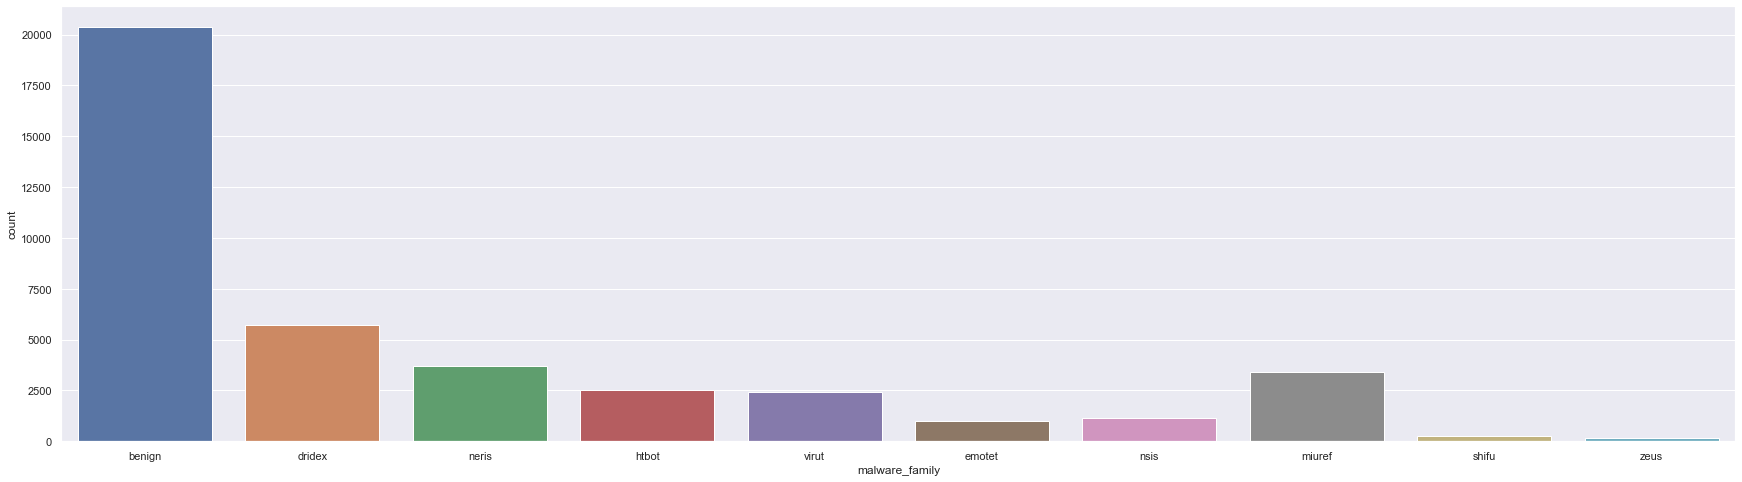

In [16]:
# Some graphs with seaborn
'''
Using the seaborn library, we can plot graphs, please refer to the documentation 
https://seaborn.pydata.org/
for examples and help.

In this cell we first set the figure/image size to 30in (width) and 8in (height).
And afterwards we plot with a counting chart 'countplot', where we want to see the count
of samples for each class in the label of 'malware_family'.
'''
sns.set(rc={'figure.figsize':(30,8)})
sns.countplot(data=df, x='malware_family')


<AxesSubplot:>

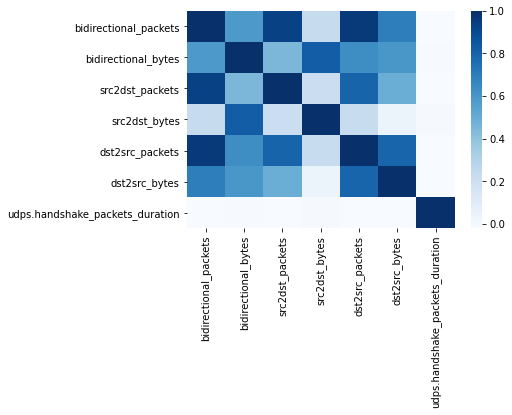

In [25]:
'''
Here we use seaborn to see the correlation between all numerical simple-1d features available in 
the dataframe using df.corr() which gives us the correlation matrix and then plotting it using
sns.heatmap(...).
'''
sns.heatmap(df[['bidirectional_packets', 'bidirectional_bytes', 'src2dst_packets',
              'src2dst_bytes', 'dst2src_packets', 'dst2src_bytes', 
              'udps.handshake_packets_duration']].corr(), cmap='Blues')

<AxesSubplot:xlabel='malware_family', ylabel='bidirectional_bytes'>

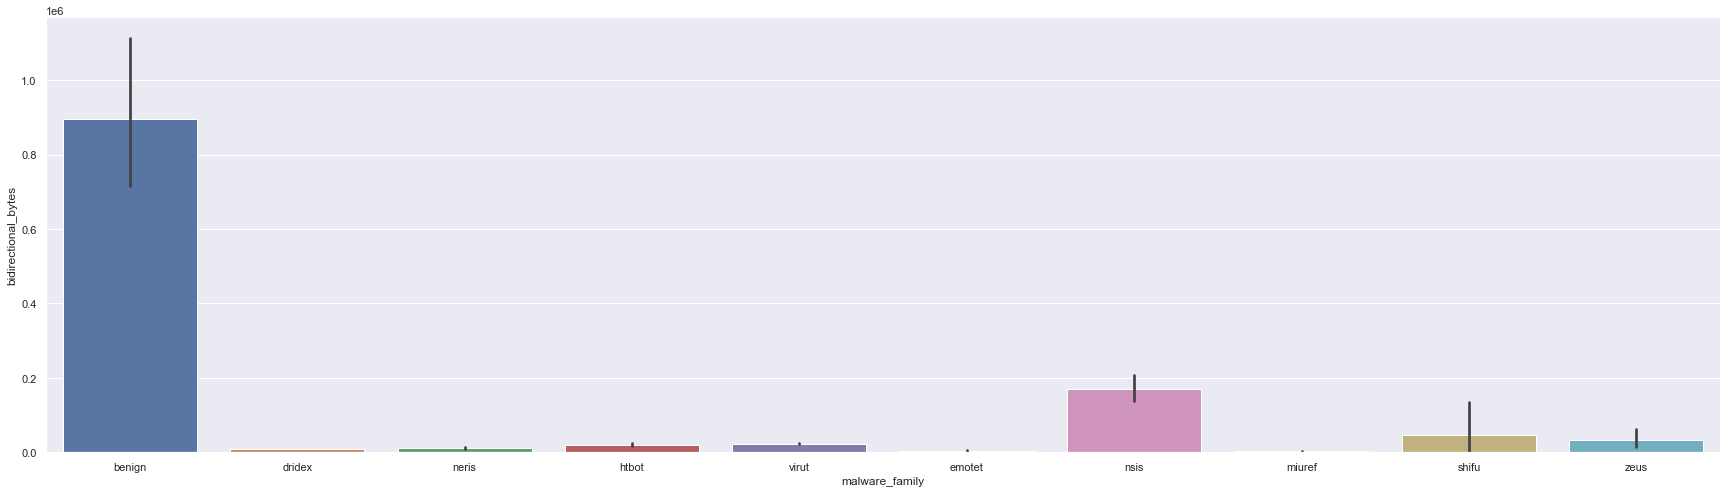

In [18]:
# Some graphs with seaborn
'''
Plotting the amount of bidirectional bytes in the session/flow (on average) of each class.
Along with the standard deviation.
'''
sns.set(rc={'figure.figsize':(30,8)})
sns.barplot(data=df, y='bidirectional_bytes', x='malware_family')

<AxesSubplot:xlabel='dst2src_packets', ylabel='src2dst_packets'>

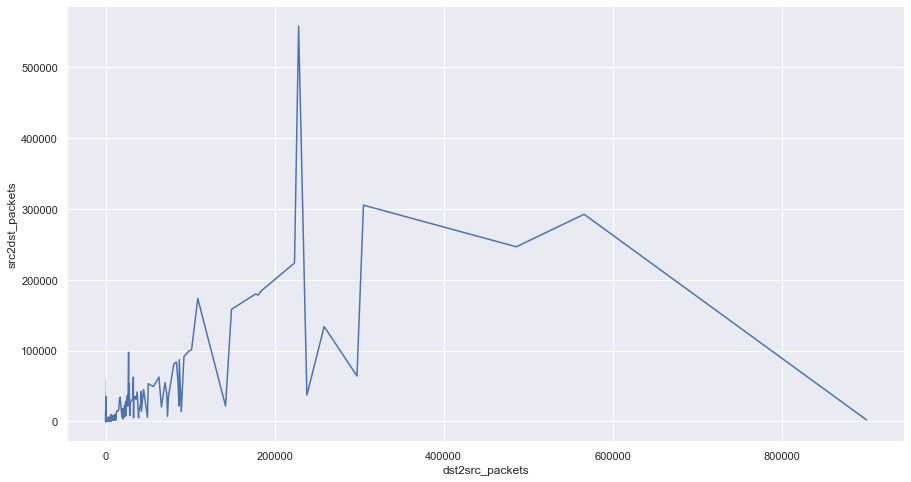

In [23]:
# Some graphs with seaborn

sns.set(rc={'figure.figsize':(15,8)})
sns.lineplot(data=df, y='src2dst_packets', x='dst2src_packets')

## Train/Fit

In [26]:
'''
There are 2 type of labels:
1. 'label': Binary labelling of {benign, malware} 
2. 'malware_family': Multi-class labelling of benign and malware families.
'''

label_type = 'label' # or 'malware_family' for malware classification.

In [27]:
# Split data to train and test
'''
X is the features we are giving our model to train on, and Y is the labels.
in this example, we chose 3 numeric simple-1d features to use as input to our model.
1. upload packets (src2dst_packets)
2. download packets (dst2src_packets)
3. amount of bytes in the flow ('bidirectional_bytes')

Please refer to NFStream documenation for most features https://www.nfstream.org/docs/api.
There are some advanced custom features that we have added: 
1. 'udps.n_bytes': a 784 length list which are the first 784 payload bytes of the flow
2. 'udps.n_bytes_per_packet': a (100,2) matrix, which is the 100 first payload bytes in the first 2 packets.
3. 'udps.protocol_header_fields': (32,4) matrix, [direction, payload size, delta_time, tcp win size] of the first 32 packets.
3. 'udps.stnn_image': (5,14) matrix, 
    first row:  bidirectional related data.
    second row: src -> dst related data.
    third row:  dst -> src related data.
    fourth row: handshake packets only related data.
    fifth row:  data packets only related data.
    
    Each row consists of 14 statistical features:
    [   iat max, iat min, iat mean, iat stddev, iat skew, 
        size min, size max, size mean, size stddev, size skew, 
        #packets, #bytes, pkts/time, bytes/time                 ]
        
    Where iat = inter arrival time or delta time, size = packet payload size.
'''
# Note that you might need to use np.stack(...) to unite all lists under a single numpy array/matrix.


X = np.stack([df['bidirectional_packets'], df['bidirectional_bytes'], df['src2dst_packets'],
              df['src2dst_bytes'], df['dst2src_packets'], df['dst2src_bytes']]).T

y = np.stack(df[label_type])


In [28]:
'''
Train/Test split - here we are splitting the data into two sets
Where we are going to train our model with X_Train and y_Train
and test it and check if we overfit or not with a test set of X_test and y_test.T

the test size is 20% of our data, and stratisfy flag makes sure that the split is 
fair to each class.
'''

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20,  # train
                                                    random_state=42, 
                                                    stratify=y)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(32590, 6) (32590,)
(8148, 6) (8148,)


In [29]:
# Get Model
'''
We choose Random Forest as our ensemble model. and then we train it on the X_Train and y_train lists
from previous cell.
'''
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100)

# Train Model

model.fit(X_train, y_train)

RandomForestClassifier()

In [30]:
# training KNN classifier

from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors = 7)
model.fit(X_train, y_train)


KNeighborsClassifier(n_neighbors=7)

In [31]:
# training ExtraTrees classifier

from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier(n_estimators=100, random_state=0)

model.fit(X_train, y_train)

ExtraTreesClassifier(random_state=0)

In [ ]:
# training SVM classifier

from sklearn.svm import SVC
model = SVC(C=50,kernel='rbf',gamma=1) 
model.fit(X_train, y_train)

## find the best algorithm for the model 

In [32]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline # For setting up pipeline

models = []

models.append(("Random Forest", RandomForestClassifier(n_estimators=100)))
models.append(("Extra Trees", ExtraTreesClassifier(n_estimators=100, random_state=0)))
models.append(("kNN", KNeighborsClassifier(n_neighbors = 7)))
#models.append(("SVM", SVC(C=50,kernel='rbf',gamma=1) ))

results = []
names = []
max_score = 0
best_model = None

for name,model in models:
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    true_labels = y_test
    cf_matrix = confusion_matrix(true_labels, predictions)
    score = np.trace(cf_matrix) / np.sum(cf_matrix)
    names.append(name)
    results.append(score)
    
    if score > max_score:
        best_model = model
        max_score = score
    
for i in range(len(names)):
    print(names[i],results[i])
    
print('\nbest model: ')
best_model.fit(X_train, y_train)

Random Forest 0.9749631811487481
Extra Trees 0.9761904761904762
kNN 0.9636720667648503

best model: 


ExtraTreesClassifier(random_state=0)

## Test/Predict

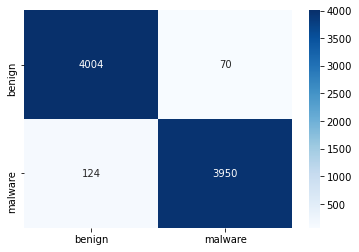

In [33]:
# Test Model/Predict
'''
We let the model predict some samples and then show on a confusion matrix plot the results.
All results such as classification report, confusion matrix and plot, are saved into a 
time stamped directory under reports/ 
'''
#predictions = model.predict(X_test)

predictions = best_model.predict(X_test)
true_labels = y_test
cf_matrix = confusion_matrix(true_labels, predictions)

heatmap = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

# Save results in file
save_classification_report(
    classification_report(true_labels, predictions),
    cf_matrix,
    heatmap,
    'reports/'
)

In [34]:
'''
There are two types of submissions:
1. 'val': Validation set, a small sized test to check your results with - should be private.
2. 'test': Test set - a bigger test - this is the public submission.
'''

#submission_type = 'val' # other option: 'test'
submission_type = 'test'

In [35]:
'''
Load the validation or test data into a DataFrame from the CSV, check that the path is correct.
'''
df_test = pd.read_csv(f'./datasets/{dataset_type}/x_{submission_type}.csv')
df_test = preprocess(df_test, process_labels=False)
df_test

,Unnamed: 0.1,expiration_id,src_ip,src_mac,src_oui,src_port,dst_ip,dst_mac,dst_oui,dst_port,...,requested_server_name,client_fingerprint,server_fingerprint,user_agent,content_type,udps.n_bytes,udps.protocol_header_fields,udps.handshake_packets_duration,udps.n_bytes_per_packet,udps.stnn_image
0,NaN,0,10.0.2.15,08:00:27:a3:83:43,08:00:27,51843,104.83.106.154,52:54:00:12:35:02,52:54:00,443,...,px.moatads.com,1a5fe5677b0e4fbbc854e8908225637d,2b33c1374db4ddf06942f92373c0b54b,NaN,NaN,"[0.08627450980392157, 0.011764705882352941, 0....","[[0, 0, 0, 8192], [1, 0, 37, 65535], [0, 0, 2,...",-0.358614,"[[0.08627450980392157, 0.011764705882352941, 0...","[[0.0, 10102.0, 1892.0, 3981.0293, 1.6012833, ..."
1,43500.0,0,10.0.2.108,08:00:27:fb:bb:39,08:00:27,64731,93.189.89.83,52:54:00:12:35:02,52:54:00,8080,...,93.189.89.83,NaN,NaN,Mozilla/5.0 (Windows NT 6.1; Trident/7.0; rv:1...,octet/binary,"[0.3137254901960784, 0.30980392156862746, 0.32...","[[0, 0, 0, 20480], [1, 0, 50, 65535], [0, 0, 1...",1.955969,"[[0.3137254901960784, 0.30980392156862746, 0.3...","[[0.0, 191349060.0, 11919972.0, 46904304.0, 3...."
2,32635.0,0,147.32.84.165,08:00:27:b5:b7:19,08:00:27,3328,87.248.203.253,00:1e:49:db:19:c3,00:1e:49,80,...,cdn3.cpmstar.com,NaN,NaN,Mozilla/4.0 (compatible; MSIE 6.0; Windows NT ...,application/x-shockwave-flash,"[0.2784313725490196, 0.27058823529411763, 0.32...","[[0, 0, 0, 64240], [1, 0, 16, 65535], [0, 0, 1...",-0.358614,"[[0.2784313725490196, 0.27058823529411763, 0.3...","[[0.0, 147.0, 13.65625, 33.916035, 2.9169044, ..."
3,NaN,0,10.0.0.9,fc:aa:14:7a:f7:ea,fc:aa:14,58318,104.244.43.37,c0:ff:d4:7f:d7:4d,c0:ff:d4,443,...,v.cdn.vine.co,07b4162d4db57554961824a21c4a0fde,a9f50de6377ae7c6dbaabc53f089ac30,NaN,NaN,"[0.08627450980392157, 0.011764705882352941, 0....","[[0, 0, 0, 29200], [1, 0, 75, 14480], [0, 0, 0...",-0.358614,"[[0.08627450980392157, 0.011764705882352941, 0...","[[0.0, 7006.0, 348.2381, 1525.779, 4.245826, 6..."
4,NaN,0,131.202.240.150,98:90:96:a0:58:2f,98:90:96,45116,209.148.205.26,e8:e7:32:3c:65:50,e8:e7:32,443,...,fbstatic-a.akamaihd.net,cb986deb1c471bb53a135ac3d264bbc9,d20f67338c838e0c19a9809fead89be9,NaN,NaN,"[0.08627450980392157, 0.011764705882352941, 0....","[[0, 0, 0, 29200], [1, 0, 22, 14480], [0, 0, 0...",-0.358614,"[[0.08627450980392157, 0.011764705882352941, 0...","[[0.0, 58981.0, 6003.9, 17874.715, 2.6596859, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11635,25065.0,0,10.0.2.103,08:00:27:3d:00:32,08:00:27,56078,200.159.128.132,52:54:00:12:35:02,52:54:00,8080,...,200.159.128.132,NaN,NaN,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,text/html,"[0.3137254901960784, 0.30980392156862746, 0.32...","[[0, 0, 0, 8192], [1, 0, 247, 65535], [0, 0, 0...",-0.358613,"[[0.3137254901960784, 0.30980392156862746, 0.3...","[[0.0, 150249.0, 17080.9, 47027.883, 2.618624,..."
11636,37401.0,0,10.0.2.108,08:00:27:fb:bb:39,08:00:27,52533,93.189.89.83,52:54:00:12:35:02,52:54:00,8080,...,93.189.89.83,NaN,NaN,Mozilla/5.0 (Windows NT 6.1; Trident/7.0; rv:1...,octet/binary,"[0.3137254901960784, 0.30980392156862746, 0.32...","[[0, 0, 0, 20480], [1, 0, 50, 65535], [0, 0, 0...",1.964069,"[[0.3137254901960784, 0.30980392156862746, 0.3...","[[0.0, 191428740.0, 11961686.0, 47068644.0, 3...."
11637,NaN,0,10.0.2.15,08:00:27:a3:83:43,08:00:27,49832,23.205.238.64,52:54:00:12:35:02,52:54:00,443,...,sb.scorecardresearch.com,1a5fe5677b0e4fbbc854e8908225637d,410b9bedaf65dd26c6fe547154d60db4,NaN,NaN,"[0.08627450980392157, 0.011764705882352941, 0....","[[0, 0, 0, 8192], [1, 0, 18, 65535], [0, 0, 3,...",-0.358614,"[[0.08627450980392157, 0.011764705882352941, 0...","[[0.0, 10070.0, 3167.0, 4683.001, 0.8081715, 5..."
11638,28662.0,0,10.0.2.109,08:00:27:61:d3:d3,08:00:27,53589,194.247.12.49,52:54:00:12:35:02,52:54:00,16455,...,NaN,NaN,NaN,NaN,NaN,"[0.01568627450980392, 0.0, 0.8, 0.933333333333...","[[0, 0, 0, 8192], [1, 0, 99, 65535], [0, 0, 0,...",-0.358614,"[[0.01568627450980392, 0.0, 0.8, 0.93333333333...","[[0.

In [36]:
# Test Model/Predict
'''
Here we extract again our 3 features, and let the model predict results over the validiation or test set.
the results are saved under the name of 'predictions.txt' which you might need to upload to evalai website.
'''


X = np.stack([df_test['bidirectional_packets'], df_test['bidirectional_bytes'], df_test['src2dst_packets'],
              df_test['src2dst_bytes'], df_test['dst2src_packets'], df_test['dst2src_bytes']]).T

#predictions = model.predict(X)

predictions = best_model.predict(X)


enc = LabelEncoder()
np.savetxt('predictions.txt', enc.fit_transform(predictions), fmt='%2d')